In [3]:
# --- upgrade pip
!python -m pip install --upgrade pip

# --- pin numpy to TF-compatible version
!pip uninstall -y numpy
!pip install numpy==1.26.4

# --- core stack (TensorFlow + supporting libraries)
!pip install tensorflow==2.15.0
!pip install scikit-learn==1.4.2 pandas==2.2.2 matplotlib==3.8.4 seaborn==0.13.2


Defaulting to user installation because normal site-packages is not writeable
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
You can safely remove it manually.
You can safely remove it manually.
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
Defaulting to u

In [4]:
import numpy as np
import tensorflow as tf

print(" NumPy version:", np.__version__)
print(" TensorFlow version:", tf.__version__)


 NumPy version: 1.26.4
 TensorFlow version: 2.15.0


In [5]:
# ---- core
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- ML / NN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# pretty plots
plt.rcParams["figure.figsize"] = (8, 4)
sns.set(style="whitegrid")

DATA_PATH = "train.csv"   # change if you placed it elsewhere
SEED = 42
np.random.seed(SEED)


In [6]:
#LOAD DATASET

In [7]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Missing values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


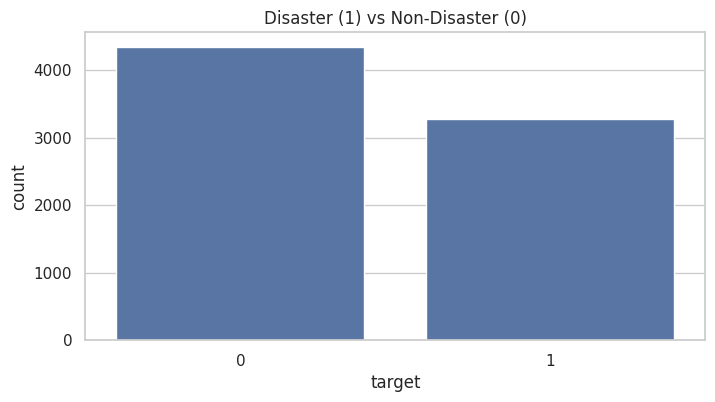

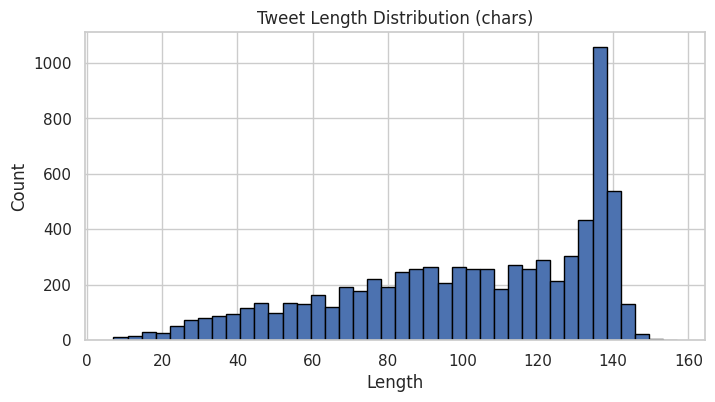

In [7]:
print("Missing values:\n", df.isnull().sum())

# class balance
sns.countplot(x="target", data=df)
plt.title("Disaster (1) vs Non-Disaster (0)")
plt.show()

# tweet length (chars)
df["text_len"] = df["text"].str.len()
plt.hist(df["text_len"], bins=40, edgecolor="black")
plt.title("Tweet Length Distribution (chars)")
plt.xlabel("Length"); plt.ylabel("Count")
plt.show()


In [8]:
#DATA CLEANING

In [9]:
def clean_text(text: str) -> str:
    text = re.sub(r"http\S+|www\S+", " ", text)      # URLs
    text = re.sub(r"@\w+|#", " ", text)              # mentions & hashtags
    text = re.sub(r"[^A-Za-z\s]", " ", text)         # punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

df["clean_text"] = df["text"].astype(str).apply(clean_text)
df[["text", "clean_text"]].head(5)


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


In [10]:
#Tokenize & pad

In [11]:
MAX_VOCAB = 20_000
MAX_LEN   = 64

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

seqs   = tokenizer.texts_to_sequences(df["clean_text"])
padded = pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")

print("Vocab size (capped):", min(MAX_VOCAB, len(tokenizer.word_index)))
print("Padded shape:", padded.shape)


Vocab size (capped): 14028
Padded shape: (7613, 64)


In [12]:
#Train/validation split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    padded, df["target"].values,
    test_size=0.20, stratify=df["target"].values, random_state=SEED
)
print("Train:", X_train.shape, " | Val:", X_val.shape)


Train: (6090, 64)  | Val: (1523, 64)


In [14]:
#Build LSTM baseline

In [15]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation="relu"),
    Dropout(0.4),
    Dense(1, activation="sigmoid"),
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


2025-11-14 17:55:49.603424: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 128)           2560000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2667137 (10.17 MB)
Trainable params: 2667137 (10.17 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [16]:
#TRAIN

In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64,
    verbose=1
)


Epoch 1/5
96/96 [==============================] - 7s 45ms/step - loss: 0.5711 - accuracy: 0.6939 - val_loss: 0.4428 - val_accuracy: 0.8109
Epoch 2/5
96/96 [==============================] - 4s 42ms/step - loss: 0.3320 - accuracy: 0.8635 - val_loss: 0.4562 - val_accuracy: 0.7945
Epoch 3/5
96/96 [==============================] - 4s 42ms/step - loss: 0.2170 - accuracy: 0.9205 - val_loss: 0.5203 - val_accuracy: 0.7682
Epoch 4/5
96/96 [==============================] - 4s 42ms/step - loss: 0.1446 - accuracy: 0.9511 - val_loss: 0.6192 - val_accuracy: 0.8056
Epoch 5/5
96/96 [==============================] - 4s 42ms/step - loss: 0.1166 - accuracy: 0.9591 - val_loss: 0.7314 - val_accuracy: 0.7682


In [18]:
#Curves (loss & accuracy)

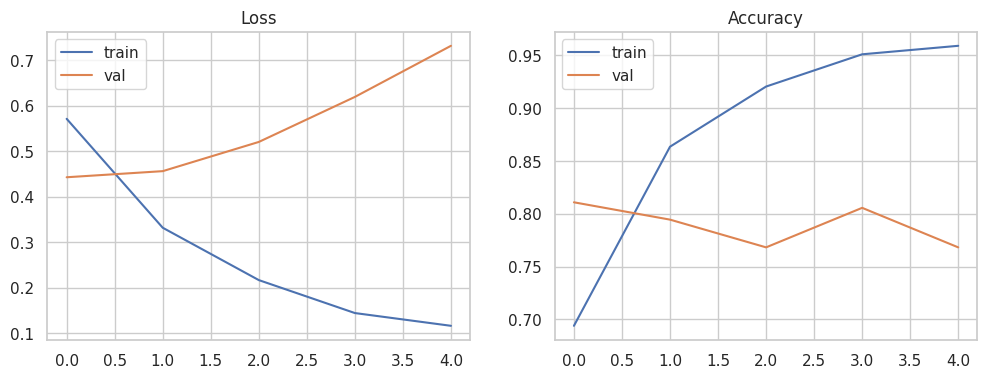

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(history.history["loss"], label="train")
ax[0].plot(history.history["val_loss"], label="val")
ax[0].set_title("Loss"); ax[0].legend()

ax[1].plot(history.history["accuracy"], label="train")
ax[1].plot(history.history["val_accuracy"], label="val")
ax[1].set_title("Accuracy"); ax[1].legend()

plt.show()


In [20]:
#Evaluation (metrics + confusion matrix)

48/48 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0      0.832     0.745     0.786       869
           1      0.702     0.800     0.748       654

    accuracy                          0.768      1523
   macro avg      0.767     0.772     0.767      1523
weighted avg      0.776     0.768     0.769      1523



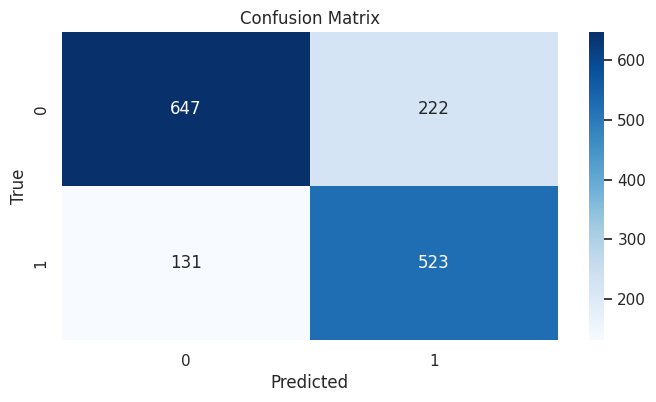

In [21]:
y_prob = model.predict(X_val)
y_pred = (y_prob > 0.5).astype("int32")

print(classification_report(y_val, y_pred, digits=3))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [22]:
#Save artifacts

In [23]:
model.save("lstm_baseline.h5")
with open("training_history.json", "w") as f:
    json.dump(history.history, f)
print("Saved: lstm_baseline.h5 and training_history.json")


Saved: lstm_baseline.h5 and training_history.json


/home/u.mm336067/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
 #Week-3 / Intermediate Update 2  
## Experiments, Evaluation, and Refinements – Disaster Tweet Classification

In [25]:

!pip uninstall -y pyarrow

!pip install --user "numpy==1.26.4" "scikit-learn==1.4.2"


Found existing installation: pyarrow 11.0.0
Uninstalling pyarrow-11.0.0:
ERROR: Exception:
Traceback (most recent call last):
  File "/sw/eb/sw/Anaconda3/2023.09-0/lib/python3.11/shutil.py", line 825, in move
    os.rename(src, real_dst)
OSError: [Errno 18] Invalid cross-device link: '/ztank/sw/eb/sw/Anaconda3/2023.09-0/bin/plasma_store' -> '/tmp/job.259327/pip-uninstall-qcw7jpcr/plasma_store'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/u.mm336067/.local/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 107, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "/home/u.mm336067/.local/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 98, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/u.mm336067/.local/lib/python3.11/site-packages/pip/_internal/commands/uninstall.py", line 105, in run
    uninstall_pat

In [26]:

!pip uninstall -y scikit-learn


Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


In [28]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [29]:
df["text_len"] = df["text"].str.len()
print(df["target"].value_counts())
df[["text_len"]].describe()


target
0    4342
1    3271
Name: count, dtype: int64


,text_len
count,7613.000000
mean,101.037436
std,33.781325
min,7.000000
25%,78.000000
50%,107.000000
75%,133.000000
max,157.000000


In [30]:
def clean_text(text: str) -> str:
    text = re.sub(r"http\S+|www\S+", " ", text)      # URLs
    text = re.sub(r"@\w+|#", " ", text)              # mentions & hashtags
    text = re.sub(r"[^A-Za-z\s]", " ", text)         # punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

df["clean_text"] = df["text"].astype(str).apply(clean_text)
df[["text", "clean_text"]].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


In [31]:
# Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

seqs = tokenizer.texts_to_sequences(df["clean_text"])
padded = pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")

print("Padded shape:", padded.shape)

X_train, X_val, y_train, y_val = train_test_split(
    padded,
    df["target"].values,
    test_size=0.20,
    stratify=df["target"].values,
    random_state=SEED
)

print("Train:", X_train.shape, " | Val:", X_val.shape)


Padded shape: (7613, 64)
Train: (6090, 64)  | Val: (1523, 64)


In [32]:
def build_lstm_model(
    vocab_size=MAX_VOCAB,
    embed_dim=128,
    lstm_units=64,
    dense_units=64,
    dropout_rate=0.4,
    input_len=MAX_LEN,
):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=input_len),
        Bidirectional(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3)),
        Dense(dense_units, activation="relu"),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def build_gru_model(
    vocab_size=MAX_VOCAB,
    embed_dim=128,
    gru_units=64,
    dense_units=64,
    dropout_rate=0.4,
    input_len=MAX_LEN,
):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=input_len),
        Bidirectional(GRU(gru_units, dropout=0.3, recurrent_dropout=0.3)),
        Dense(dense_units, activation="relu"),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [33]:
results = []          # list of dicts with metrics per model
histories = {}        # model_name -> history.history
models = {}           # model_name -> trained model
predictions = {}      # model_name -> (y_prob, y_pred)

def train_and_evaluate(model_name, model, X_train, y_train, X_val, y_val,
                       epochs=8, batch_size=64):
    print(f"\n===== Training {model_name} =====")
    es = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=2,
        restore_best_weights=True,
        verbose=1,
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=1,
    )
    
    histories[model_name] = history.history
    models[model_name] = model
    
    # Evaluation
    y_prob = model.predict(X_val)
    y_pred = (y_prob > 0.5).astype("int32")
    predictions[model_name] = (y_prob, y_pred)
    
    report = classification_report(y_val, y_pred, digits=3, output_dict=True)
    print(classification_report(y_val, y_pred, digits=3))
    
    acc = report["accuracy"]
    f1_macro = report["macro avg"]["f1-score"]
    
    results.append({
        "model": model_name,
        "val_accuracy": acc,
        "val_f1_macro": f1_macro,
    })
    
    return history


In [8]:
#baseline model

In [34]:
baseline_model = build_lstm_model(
    embed_dim=128,
    lstm_units=64,
    dense_units=64,
    dropout_rate=0.4,
)

history_baseline = train_and_evaluate(
    "LSTM_baseline",
    baseline_model,
    X_train, y_train,
    X_val, y_val,
    epochs=5,
    batch_size=64,
)



===== Training LSTM_baseline =====
Epoch 1/5
96/96 [==============================] - 7s 45ms/step - loss: 0.5881 - accuracy: 0.6788 - val_loss: 0.4420 - val_accuracy: 0.8037
Epoch 2/5
96/96 [==============================] - 4s 42ms/step - loss: 0.3445 - accuracy: 0.8622 - val_loss: 0.4493 - val_accuracy: 0.8142
Epoch 3/5
96/96 [==============================] - 4s 42ms/step - loss: 0.2165 - accuracy: 0.9220 - val_loss: 0.5019 - val_accuracy: 0.7919
Epoch 3: early stopping
48/48 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0      0.794     0.886     0.837       869
           1      0.821     0.694     0.752       654

    accuracy                          0.804      1523
   macro avg      0.807     0.790     0.795      1523
weighted avg      0.805     0.804     0.801      1523



In [35]:
#Experiment 2 -tuned LSTM (MORE REGULARIZATION + EARLY STOPING)

In [36]:
tuned_lstm = build_lstm_model(
    embed_dim=128,
    lstm_units=48,      # slightly fewer units
    dense_units=64,
    dropout_rate=0.5,   # stronger dropout
)

history_lstm_tuned = train_and_evaluate(
    "LSTM_tuned",
    tuned_lstm,
    X_train, y_train,
    X_val, y_val,
    epochs=10,
    batch_size=64,
)



===== Training LSTM_tuned =====
Epoch 1/10
96/96 [==============================] - 7s 43ms/step - loss: 0.5914 - accuracy: 0.6811 - val_loss: 0.4430 - val_accuracy: 0.7984
Epoch 2/10
96/96 [==============================] - 4s 37ms/step - loss: 0.3410 - accuracy: 0.8649 - val_loss: 0.4726 - val_accuracy: 0.8017
Epoch 3/10
96/96 [==============================] - 4s 37ms/step - loss: 0.2216 - accuracy: 0.9176 - val_loss: 0.4881 - val_accuracy: 0.8168
Epoch 3: early stopping
48/48 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0      0.778     0.906     0.837       869
           1      0.840     0.656     0.736       654

    accuracy                          0.798      1523
   macro avg      0.809     0.781     0.787      1523
weighted avg      0.804     0.798     0.794      1523



In [37]:
#EXPERIMENT 3 -GRU VARIENT

In [38]:
gru_model = build_gru_model(
    embed_dim=128,
    gru_units=64,
    dense_units=64,
    dropout_rate=0.4,
)

history_gru = train_and_evaluate(
    "GRU_model",
    gru_model,
    X_train, y_train,
    X_val, y_val,
    epochs=10,
    batch_size=64,
)



===== Training GRU_model =====
Epoch 1/10
96/96 [==============================] - 6s 42ms/step - loss: 0.5892 - accuracy: 0.6757 - val_loss: 0.4411 - val_accuracy: 0.7984
Epoch 2/10
96/96 [==============================] - 4s 39ms/step - loss: 0.3434 - accuracy: 0.8570 - val_loss: 0.4389 - val_accuracy: 0.8201
Epoch 3/10
96/96 [==============================] - 4s 39ms/step - loss: 0.2129 - accuracy: 0.9215 - val_loss: 0.5644 - val_accuracy: 0.7695
Epoch 4/10
96/96 [==============================] - 4s 39ms/step - loss: 0.1523 - accuracy: 0.9450 - val_loss: 0.5965 - val_accuracy: 0.7925
Epoch 4: early stopping
48/48 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0      0.812     0.891     0.850       869
           1      0.833     0.726     0.776       654

    accuracy                          0.820      1523
   macro avg      0.823     0.808     0.813      1523
weighted avg      0.821     0.820     0.818      1523



In [39]:
#COMPARE EXPERIMENTS 

In [40]:
results_df = pd.DataFrame(results)
results_df


,model,val_accuracy,val_f1_macro
0,LSTM_baseline,0.803677,0.794845
1,LSTM_tuned,0.798424,0.786635
2,GRU_model,0.820092,0.812880


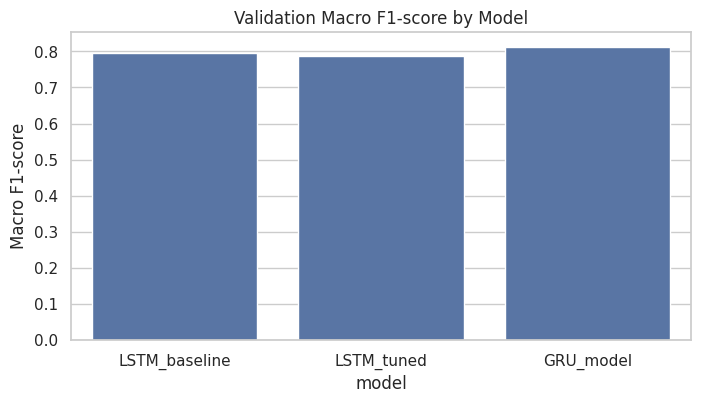

In [41]:
plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="model", y="val_f1_macro")
plt.title("Validation Macro F1-score by Model")
plt.ylabel("Macro F1-score")
plt.show()


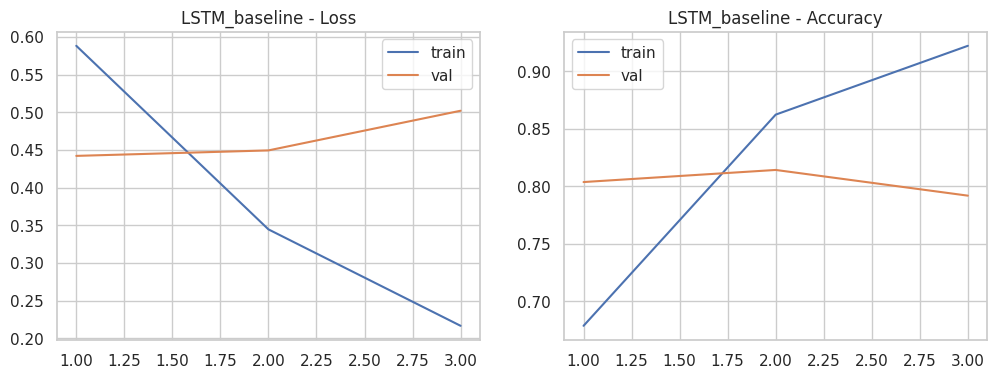

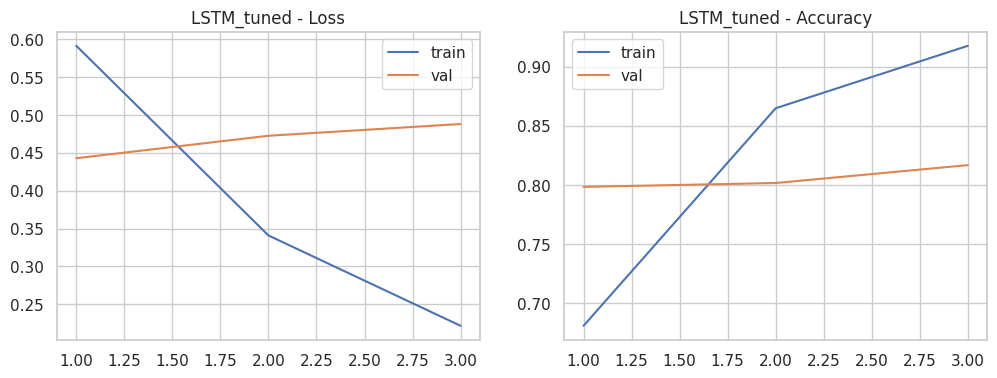

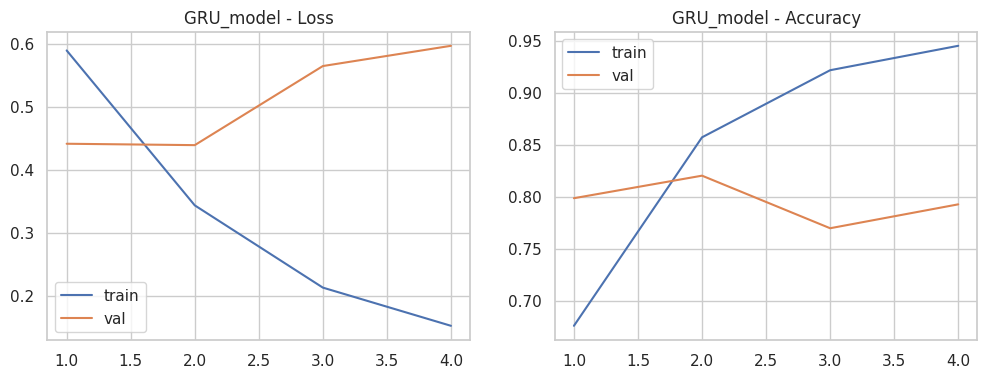

In [42]:
def plot_history(model_name, history_dict):
    epochs = range(1, len(history_dict["loss"]) + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    
    ax[0].plot(epochs, history_dict["loss"], label="train")
    ax[0].plot(epochs, history_dict["val_loss"], label="val")
    ax[0].set_title(f"{model_name} - Loss")
    ax[0].legend()
    
    ax[1].plot(epochs, history_dict["accuracy"], label="train")
    ax[1].plot(epochs, history_dict["val_accuracy"], label="val")
    ax[1].set_title(f"{model_name} - Accuracy")
    ax[1].legend()
    
    plt.show()

for name, hist in histories.items():
    plot_history(name, hist)


Best model: GRU_model


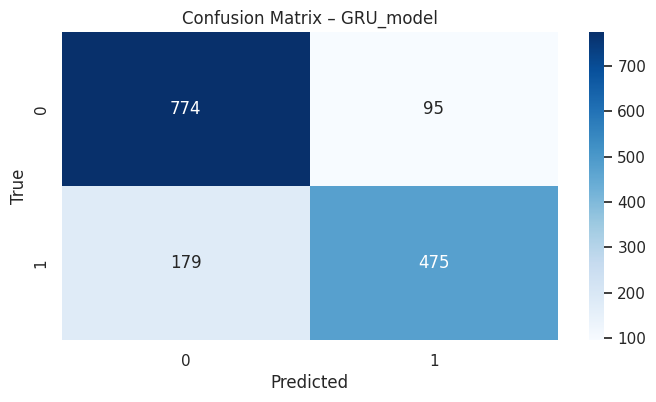

In [43]:
# pick model with best macro F1
best_idx = results_df["val_f1_macro"].idxmax()
best_name = results_df.loc[best_idx, "model"]
print("Best model:", best_name)

_, best_y_pred = predictions[best_name]

cm = confusion_matrix(y_val, best_y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_name}")
plt.show()


In [44]:
best_model = models[best_name]
best_model.save(f"{best_name}_week3_best.keras")

with open("week3_results.json", "w") as f:
    json.dump({
        "results": results,
        "histories": histories,
        "best_model": best_name,
    }, f)

print("Saved:", f"{best_name}_week3_best.keras and week3_results.json")


Saved: GRU_model_week3_best.keras and week3_results.json
